In [1]:
import argparse
import cv2
import os
import logging
import uuid
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skew
from utilities.AutomaticSegmentation import *

In [4]:
def __seed_point_in_rectangle(seed_pt, rect):
    x,y,w,h = rect
    return (
        seed_pt[1] > x and 
        seed_pt[1] < x + w and
        seed_pt[0] > y and 
        seed_pt[0] < y + h
    )

def __rectangle_area(rect):
    return rect[2] * rect[3]

In [46]:
# This kernel size seems incredibly important. (2,2) and (4,4) are good. (16,16) not so much
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2, 2))

base_path = "../TestImages/bank"

for impath in os.listdir(base_path):
    
    path_to_image = "{}/{}".format(base_path, impath)
    img = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    seed_pt, ref_pt, enh = get_ROI(img)

    enh_gray = (enh*255).astype(np.uint8)
    
    I_rc = cv2.morphologyEx(
        enh_gray, 
        cv2.MORPH_CLOSE, 
        kernel)
       
#     img_morph = cv2.adaptiveThreshold(I_rc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 2)
    otsu_thresh, img_morph = cv2.threshold(I_rc, 0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # bin_thresh, img_morph = cv2.threshold(I_rc, 0,255, cv2.THRESH_BINARY)
    
    im2, contours, hierarchy = cv2.findContours(
        img_morph,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE)
    
    br = [cv2.boundingRect(c) for c in contours]
    
    print("Seed point: {}".format(seed_pt))

    # Find all bounding rectangles of contours that contain the seed point
    br = [r for r in br if __seed_point_in_rectangle(seed_pt, r)]
            
    # Map all rectangles to areas
    areas = [__rectangle_area(r) for r in br]
    
    # Select the smallest contour bounding the seed point as the ROI
    min_rect = br[np.argmin(areas)]
    
    x,y,w,h = min_rect
    
    x_exp = img.shape[1] // 20
    y_exp = img.shape[0] // 20
    print("Expand factors: row {} | col: {}".format(y_exp, x_exp))
    
    cv2.rectangle(
        img,
        (max(x - x_exp, 0), max(0, y - y_exp)),
        (min(x + w + x_exp, img.shape[1]), min(y + h + y_exp, img.shape[0])),
        255,
        2)
    
    plt.figure()
    plt.scatter(x=seed_pt[1], y=seed_pt[0], s=40, c='r')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])



Seed point: [358.20512974 399.39563438]
Expand factors: row 28 | col: 35
Seed point: [218.88571429 303.54065934]
Expand factors: row 22 | col: 30
Seed point: [180.58810573 261.44933921]
Expand factors: row 22 | col: 30
Seed point: [206.88671744 250.59883307]
Expand factors: row 15 | col: 24
Seed point: [141.52175184 223.66485642]
Expand factors: row 16 | col: 24
Seed point: [210.48300229 249.43464767]
Expand factors: row 15 | col: 24
Seed point: [434.33920705 332.37665198]
Expand factors: row 35 | col: 30
Seed point: [122.00716631 214.61397875]
Expand factors: row 16 | col: 24
Seed point: [146.84678803 150.03801825]
Expand factors: row 14 | col: 14
Seed point: [117.68767314 255.20720234]
Expand factors: row 16 | col: 24
Seed point: [130.84306985 209.63089079]
Expand factors: row 16 | col: 24


In [41]:
# constants
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4, 4))

path_to_image = "../TestImages/bank/cbad1e01-15bf-4451-9ddb-212ec162ea2e.png"
img = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)

seed_pt, ref_pt, enh = get_ROI(img)
print("Seed point: {}".format(seed_pt))


enh_gray = (enh*255).astype(np.uint8)

I_rc = cv2.morphologyEx(
    enh_gray, 
    cv2.MORPH_CLOSE, 
    kernel)
       
# img_morph = cv2.adaptiveThreshold(I_rc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
otsu_thresh, img_morph = cv2.threshold(I_rc, 0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# bin_thresh, img_morph = cv2.threshold(I_rc, 254, 255, cv2.THRESH_BINARY)


im2, contours, hierarchy = cv2.findContours(
    np.copy(img_morph),
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE)

br = [cv2.boundingRect(c) for c in contours]
print(br)

# Find all bounding rectangles of contours that contain the seed point
br = [r for r in br if __seed_point_in_rectangle(seed_pt, r)]
print(br)

# Map all rectangles to areas
areas = [__rectangle_area(r) for r in br]

# Select the smallest contour bounding the seed point as the ROI
min_rect = br[np.argmin(areas)]
print("Minimum rect: {}".format(min_rect))

x,y,w,h = min_rect

x_exp = img.shape[1] // 15 # Hand chosen values. Poor methodology
y_exp = img.shape[0] // 15
print("Expand factors: row {} | col: {}".format(y_exp, x_exp))
    

Seed point: [180.58810573 261.44933921]
[(334, 429, 5, 5), (449, 390, 5, 8), (380, 389, 4, 2), (373, 385, 3, 1), (16, 360, 16, 17), (20, 349, 4, 2), (27, 307, 5, 3), (553, 230, 13, 3), (570, 228, 4, 2), (586, 226, 2, 1), (577, 225, 6, 4), (38, 225, 1, 3), (67, 210, 1, 1), (37, 200, 26, 13), (40, 184, 5, 4), (32, 173, 6, 5), (450, 165, 2, 1), (520, 152, 8, 2), (16, 150, 4, 2), (595, 130, 1, 1), (582, 127, 1, 1), (579, 123, 39, 320), (520, 123, 6, 2), (438, 121, 2, 2), (400, 116, 2, 2), (578, 113, 2, 1), (429, 111, 2, 2), (400, 109, 10, 7), (566, 108, 2, 1), (435, 105, 11, 6), (592, 101, 1, 1), (554, 101, 9, 12), (88, 101, 8, 3), (556, 99, 1, 1), (558, 96, 1, 1), (522, 96, 1, 1), (493, 96, 2, 1), (445, 93, 3, 1), (429, 87, 5, 2), (80, 81, 4, 2), (31, 73, 29, 16), (431, 71, 2, 1), (31, 67, 14, 3), (113, 65, 1, 1), (58, 65, 7, 4), (398, 62, 1, 1), (76, 62, 6, 5), (421, 57, 17, 8), (418, 53, 1, 1), (391, 53, 1, 1), (76, 53, 3, 1), (67, 53, 4, 2), (94, 51, 21, 15), (417, 46, 1, 1), (352, 44,

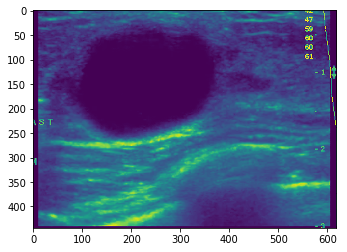

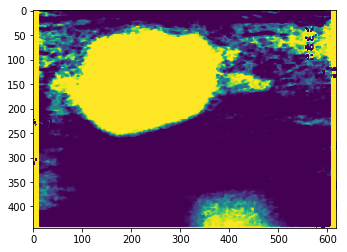

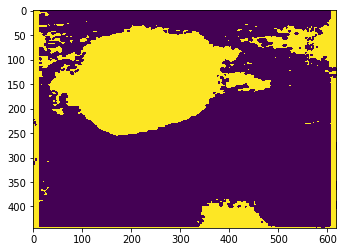

In [39]:
plt.imshow(img)
plt.figure()
plt.imshow(I_rc)
plt.figure()
plt.imshow(img_morph)

In [45]:
%matplotlib

Using matplotlib backend: MacOSX
